The main focus of this notebook is to preprocess a dataset to prepare it for the application of machine learning algorithms and fairness evaluation. The notebook also includes visualizations and statistics to help understand the distribution and correlations of the data.

**PLEASE NOTE**: The notebook must be configured with a dataset and some configuration variables.  
The ***protected attributes*** must be categorical and binary (0,1), but the original column must be mantained as a continuous variable.

##Libraries

In order to run this notebook in Google Colab, you have to:
1. Upload the project folder to your Google Drive
2. Mount your Google Drive in the next code cell
3. Update the `path_to_project` variable, with the path to the project folder in your Google Drive (e.g. `path_to_project = '/content/drive/MyDrive/Colab/project'`), this can be seen from the file tab on the left of the Colab interface
4. Update the pip installation command  (e.g. `!pip install -r /content/drive/MyDrive/Colab/project/requirements.txt`)

In [52]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  import sys
  path_to_project = '/content/drive/MyDrive/FairAlgorithm'
  sys.path.append(path_to_project)
  !sudo apt install libcairo2-dev pkg-config python3-dev
  !{sys.executable} -m pip install -U ydata-profiling[notebook]
  !pip install jupyter-contrib-nbextensions
  !jupyter nbextension enable --py widgetsnbextension
  IN_COLAB = True
except:
  IN_COLAB = False

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libcairo2-dev is already the newest version (1.16.0-5ubuntu2).
pkg-config is already the newest version (0.29.2-1ubuntu3).
python3-dev is already the newest version (3.10.6-1~22.04.1).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 47 not upgraded.
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [53]:
import numpy as np
import pandas as pd
import plotly
np.random.seed(0)
from rich import print
from rich.columns import Columns
from rich.panel import Panel
from rich.align import Align
from source.utils.print_util import *
from source.utils.data_preprocessing import *
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt

## Configuration

In the next code cell, set all the variables that are used throughout the notebook.  
The variables are used to configure the notebook, and to set the paths to the data files.

Modify the variables in the next code cell to configure the notebook
- `dataset_path`: The path to the dataset file.
- `Y`: The target feature to predict.
- `Y_labels`: The labels for the target feature.

In [54]:
dataset_path = path_to_project + '/data/raw/aids.csv' if IN_COLAB else 'data/raw/aids.csv'
Y = 'cid'
Y_labels = 'Death', 'Censoring'

## Data load and exploration


Data is loaded from the file specified in the `dataset_path` variable using the `pandas` library.  
[pandas](https://pandas.pydata.org) is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool,
built on top of the Python programming language.

In [55]:
df = pd.read_csv(dataset_path)
df.columns.tolist()

['pidnum',
 'cid',
 'time',
 'trt',
 'age',
 'wtkg',
 'hemo',
 'homo',
 'drugs',
 'karnof',
 'oprior',
 'z30',
 'zprior',
 'preanti',
 'race',
 'gender',
 'str2',
 'strat',
 'symptom',
 'treat',
 'offtrt',
 'cd40',
 'cd420',
 'cd80',
 'cd820']

In [56]:
df.head(6)

,pidnum,cid,time,trt,age,wtkg,hemo,homo,drugs,karnof,...,gender,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820
0,10056,0,948,2,48,89.8128,0,0,0,100,...,0,0,1,0,1,0,422,477,566,324
1,10059,1,1002,3,61,49.4424,0,0,0,90,...,0,1,3,0,1,0,162,218,392,564
2,10089,0,961,3,45,88.4520,0,1,1,90,...,1,1,3,0,1,1,326,274,2063,1893
3,10093,0,1166,3,47,85.2768,0,1,0,100,...,1,1,3,0,1,0,287,394,1590,966
4,10124,0,1090,0,43,66.6792,0,1,0,100,...,1,1,3,0,0,0,504,353,870,782
5,10140,0,1181,1,46,88.9056,0,1,1,100,...,1,1,3,0,1,0,235,339,860,1060


In [57]:
import os
path_to_project = '/content/drive/MyDrive/FairAlgorithm'
os.makedirs(path_to_project, exist_ok=True)

profile = ProfileReport(df, title='Aids Analysis Raw')
html_file = profile.to_file(path_to_project + '/data/reports/aids_analysis_raw.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

**Statistics on the raw dataset**

Information about the dataset.

Percentage of samples for each protected attribute and the target. The protected attribute 'age' at the moment is not considered; it will appear after the categorization of the attribute.

In [58]:
samples = df.shape[0]

In [59]:
#race
race = 'race'
race_zero = df[df[race] == 0]
count_race_zero = len(race_zero)
print(f"percentage of samples with race = 0 (non-white) : {count_race_zero/samples}")

race_one = df[df[race] == 1]
count_race_one = len(race_one)
print(f"percentage of samples with race = 1 (white): {count_race_one/samples}")


percentage of samples with race = 0 (non-white) : 0.7115474520804114

percentage of samples with race = 1 (white): 0.2884525479195886

In [60]:
homo = 'homo'
homo_zero = df[df[homo] == 0]
count_homo_zero = len(homo_zero)
print(f"percentage of samples with homo = 0 (homosexual): {count_homo_zero/samples}")

homo_one = df[df[homo] == 1]
count_homo_one = len(homo_one)
print(f"percentage of samples with homo = 1 (non-homosexual): {count_homo_one/samples}")

percentage of samples with homo = 0 (homosexual): 0.3389434315100514

percentage of samples with homo = 1 (non-homosexual): 0.6610565684899485

In [61]:
#gender
gender = 'gender'
gender_zero = df[df[gender] == 0]
count_gender_zero = len(gender_zero)
print(f"number samples with gender = 0 (female): {count_gender_zero/samples}")

gender_one = df[df[gender] == 1]
count_gender_one = len(gender_one)
print(f"number samples with gender = 1 (male): {count_gender_one/samples}")

number samples with gender = 0 (female): 0.17204301075268819

number samples with gender = 1 (male): 0.8279569892473119

In [62]:
#mortality, target
mortality_counts = df['cid'].value_counts()
print(f"number of samples per mortality: {mortality_counts}")
print(f"percentage of samples per mortality: {mortality_counts /samples}")

number of samples per mortality: cid
0    1618
1     521
Name: count, dtype: int64

percentage of samples per mortality: cid
0    0.756428
1    0.243572
Name: count, dtype: float64

Percentage of samples for each protected attribute value and for each value of target class.

In [63]:
#race
filtered_samples = df[(df[race] == 0) & (df['cid'] == 0)]
count_filtered_samples = len(filtered_samples)
print(f"Percentage of samples where cid = 0 given race = 0: {count_filtered_samples/count_race_zero}")

filtered_samples = df[(df[race] == 1) & (df['cid'] == 0)]
count_filtered_samples = len(filtered_samples)
print(f"Percentage of samples where cid = 0 given race = 1: {count_filtered_samples/count_race_one}")

filtered_samples = df[(df[race] == 0) & (df['cid'] == 1)]
count_filtered_samples = len(filtered_samples)
print(f"Percentage of samples where cid = 1 given race = 0: {count_filtered_samples/count_race_zero}")

filtered_samples = df[(df[race] == 1) & (df['cid'] == 1)]
count_filtered_samples = len(filtered_samples)
print(f"Percentage of samples where cid = 1 given race = 1: {count_filtered_samples/count_race_one}")


Percentage of samples where cid = 0 given race = 0: 0.7411300919842313

Percentage of samples where cid = 0 given race = 1: 0.7941653160453809

Percentage of samples where cid = 1 given race = 0: 0.2588699080157687

Percentage of samples where cid = 1 given race = 1: 0.20583468395461912

In [64]:
#homo
filtered_samples = df[(df[homo] == 0) & (df['cid'] == 0)]
count_filtered_samples = len(filtered_samples)
print(f"Percentage of samples where cid = 0 given homo = 0: {count_filtered_samples/count_homo_zero}")

filtered_samples = df[(df[homo] == 1) & (df['cid'] == 0)]
count_filtered_samples = len(filtered_samples)
print(f"Percentage of samples where cid = 0 given homo = 1: {count_filtered_samples/count_homo_one}")

filtered_samples = df[(df[homo] == 0) & (df['cid'] == 1)]
count_filtered_samples = len(filtered_samples)
print(f"Percentage of samples where cid = 1 given homo = 0: {count_filtered_samples/count_homo_zero}")

filtered_samples = df[(df[homo] == 1) & (df['cid'] == 1)]
count_filtered_samples = len(filtered_samples)
print(f"Percentage of samples where cid = 1 given homo = 1: {count_filtered_samples/count_homo_one}")


Percentage of samples where cid = 0 given homo = 0: 0.7889655172413793

Percentage of samples where cid = 0 given homo = 1: 0.7397454031117398

Percentage of samples where cid = 1 given homo = 0: 0.2110344827586207

Percentage of samples where cid = 1 given homo = 1: 0.26025459688826025

In [65]:
#gender
filtered_samples = df[(df['gender'] == 0) & (df['cid'] == 0)]
count_filtered_samples = len(filtered_samples)
print(f"Percentage of samples where cid = 0 given gender = 0: {count_filtered_samples/count_gender_zero}")

filtered_samples = df[(df['gender'] == 1) & (df['cid'] == 0)]
count_filtered_samples = len(filtered_samples)
print(f"Percentage of samples where cid = 0 given gender = 1: {count_filtered_samples/count_gender_one}")

filtered_samples = df[(df['gender'] == 0) & (df['cid'] == 1)]
count_filtered_samples = len(filtered_samples)
print(f"Percentage of samples where cid = 1 given gender = 0: {count_filtered_samples/count_gender_zero}")

filtered_samples = df[(df['gender'] == 1) & (df['cid'] == 1)]
count_filtered_samples = len(filtered_samples)
print(f"Percentage of samples where cid = 1 given gender = 1: {count_filtered_samples/count_gender_one}")


Percentage of samples where cid = 0 given gender = 0: 0.7989130434782609

Percentage of samples where cid = 0 given gender = 1: 0.7476002258610954

Percentage of samples where cid = 1 given gender = 0: 0.20108695652173914

Percentage of samples where cid = 1 given gender = 1: 0.2523997741389046

**Columns transformation**

Transform columns with continuous attribute values, or categorical attributes expressed by strings, into categorical attributes expressed by numbers and booleans (0, 1).

For the attribute age, the median was used to categorize the feature in two classes.

In [66]:
#age
import statistics
samples = df.shape[0]
x = statistics.median(df['age'])
print(f"{x}")

df["age_cat"] = df["age"].apply(lambda age: 1 if age > x else 0)

34

Changing the value of the features homo and race to have the discriminated group with the value 0 and the priviledged group with value 1.

In [67]:
#homosexuality
homo_mapping = {1: 0, 0: 1}
df["homo_cat"] = df["homo"].map(homo_mapping) #homosexual is now 0

In [68]:
#race
race_mapping = {1: 0, 0: 1}
df["race_cat"] = df["race"].map(race_mapping) #non-white is now 0

In [69]:
df.head(6)

,pidnum,cid,time,trt,age,wtkg,hemo,homo,drugs,karnof,...,symptom,treat,offtrt,cd40,cd420,cd80,cd820,age_cat,homo_cat,race_cat
0,10056,0,948,2,48,89.8128,0,0,0,100,...,0,1,0,422,477,566,324,1,1,1
1,10059,1,1002,3,61,49.4424,0,0,0,90,...,0,1,0,162,218,392,564,1,1,1
2,10089,0,961,3,45,88.4520,0,1,1,90,...,0,1,1,326,274,2063,1893,1,0,1
3,10093,0,1166,3,47,85.2768,0,1,0,100,...,0,1,0,287,394,1590,966,1,0,1
4,10124,0,1090,0,43,66.6792,0,1,0,100,...,0,0,0,504,353,870,782,1,0,1
5,10140,0,1181,1,46,88.9056,0,1,1,100,...,0,1,0,235,339,860,1060,1,0,1


**Check for missing values**

Missing values in a dataset can introduce bias, reduce accuracy, limit the types of analyses that can be performed, and increase the complexity of analysis. Therefore, it is generally advisable to remove missing values from a dataset, as long as the amount of missing data is not too large. However, the reasons for the missing values should be carefully considered, and in some cases, imputation or specialized methods for handling missing data may be more appropriate.  

`remove_missing_values` function is used to remove rows with missing values.  

In [70]:
print(df.shape)
df[df.isna().any(axis=1)]

(2139, 28)

,pidnum,cid,time,trt,age,wtkg,hemo,homo,drugs,karnof,...,symptom,treat,offtrt,cd40,cd420,cd80,cd820,age_cat,homo_cat,race_cat


In [71]:
df = remove_missing_values(df)

╭─────────────────────────────────────────── Searching missing values ────────────────────────────────────────────╮
│                                                                                                                 │
╰──────────────────────────────────────────── NO MISSING VALUES FOUND ────────────────────────────────────────────╯

**Check for outliers**

Outliers are data points that deviate significantly from other data points in a dataset, and they can introduce bias, reduce accuracy, lead to misleading results, and increase the complexity of analysis. Outliers are generally considered bad for statistical analysis, and it is important to identify and handle them appropriately to ensure the accuracy and reliability of statistical models and analysis.

First we plot the dataset using a **box plot**, if some attribute has any point outside the box, it means that it has an outlier. We then use these attributes and **IQR** to remove the outliers.

In [72]:
df.shape

(2139, 28)

In [73]:
fig = plotly.boxplot_frame(df, y=['time', 'age', 'wtkg','karnof', 'z30', 'zprior', 'preanti','cd40', 'cd420', 'cd80', 'cd820'])
fig.show()

In [74]:
# From the plot, these attributes need further investigation on outliers, so we will use the IQR method to find and remove them
attributes = ['time', 'age', 'wtkg','karnof', 'preanti','cd40', 'cd420', 'cd80', 'cd820']
df = search_and_remove_outliers(df, attributes)

╭─ Searching outliers for the following attributes: ['time', 'age', 'wtkg', 'karnof', 'preanti', 'cd40', 'cd420',─╮
│                             ┏━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓                              │
│                             ┃ Attribute ┃ # Outliers ┃ MAX Outlier ┃ MIN Outlier ┃                              │
│                             ┡━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩                              │
│                             │   time    │     49     │     174     │     14      │                              │
│                             │    age    │     51     │     70      │     12      │                              │
│                             │   wtkg    │     50     │  159.93936  │   32.6592   │                              │
│                             │  karnof   │     7      │     70      │     70      │                              │
│                             │  preanti  │     10     │    2851     │    1856     │                              │
│                             │   cd40    │     27     │    1199     │      0      │                              │
│                             │   cd420   │     25     │    1119     │     748     │                              │
│                             │   cd80    │     65     │    5011     │    1992     │                              │
│                             │   cd820   │     37     │    3407     │    1827     │                              │
│                             └───────────┴────────────┴─────────────┴─────────────┘                              │
╰─────────────────────────────────────────────── OUTLIERS REMOVED ────────────────────────────────────────────────╯

In [75]:
df.shape

(1818, 28)

**Feature selection**

Feature selection is a process of identifying the most important and relevant features or variables that contribute the most to a predictive model. It is a crucial step in data preprocessing and analysis, and it helps to improve the accuracy, efficiency, and interpretability of the model.

The correlation matrix is plotted to identify the most correlated attributes. In this case no attribute can be removed since no value is above 0.7.

In [76]:
df_category = df[['pidnum', 'cid', 'time', 'trt', 'age_cat', 'homo_cat', 'race_cat', 'wtkg', 'hemo', 'drugs', 'karnof', 'oprior', 'z30', 'zprior', 'preanti', 'gender', 'str2', 'strat', 'symptom', 'treat', 'offtrt', 'cd40', 'cd420', 'cd80', 'cd820']].copy()
df_category.head(6)

,pidnum,cid,time,trt,age_cat,homo_cat,race_cat,wtkg,hemo,drugs,...,gender,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820
0,10056,0,948,2,1,1,1,89.8128,0,0,...,0,0,1,0,1,0,422,477,566,324
3,10093,0,1166,3,1,0,1,85.2768,0,0,...,1,1,3,0,1,0,287,394,1590,966
4,10124,0,1090,0,1,0,1,66.6792,0,0,...,1,1,3,0,0,0,504,353,870,782
5,10140,0,1181,1,1,0,1,88.9056,0,1,...,1,1,3,0,1,0,235,339,860,1060
6,10165,1,794,0,0,0,1,73.0296,0,0,...,1,1,3,0,0,0,244,225,708,699
7,10190,0,957,0,1,0,1,66.2256,0,1,...,1,1,3,0,0,0,401,366,889,720


In [77]:
df_category.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1818 entries, 0 to 2136
Data columns (total 25 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pidnum    1818 non-null   int64  
 1   cid       1818 non-null   int64  
 2   time      1818 non-null   int64  
 3   trt       1818 non-null   int64  
 4   age_cat   1818 non-null   int64  
 5   homo_cat  1818 non-null   int64  
 6   race_cat  1818 non-null   int64  
 7   wtkg      1818 non-null   float64
 8   hemo      1818 non-null   int64  
 9   drugs     1818 non-null   int64  
 10  karnof    1818 non-null   int64  
 11  oprior    1818 non-null   int64  
 12  z30       1818 non-null   int64  
 13  zprior    1818 non-null   int64  
 14  preanti   1818 non-null   int64  
 15  gender    1818 non-null   int64  
 16  str2      1818 non-null   int64  
 17  strat     1818 non-null   int64  
 18  symptom   1818 non-null   int64  
 19  treat     1818 non-null   int64  
 20  offtrt    1818 non-null   int64  
 

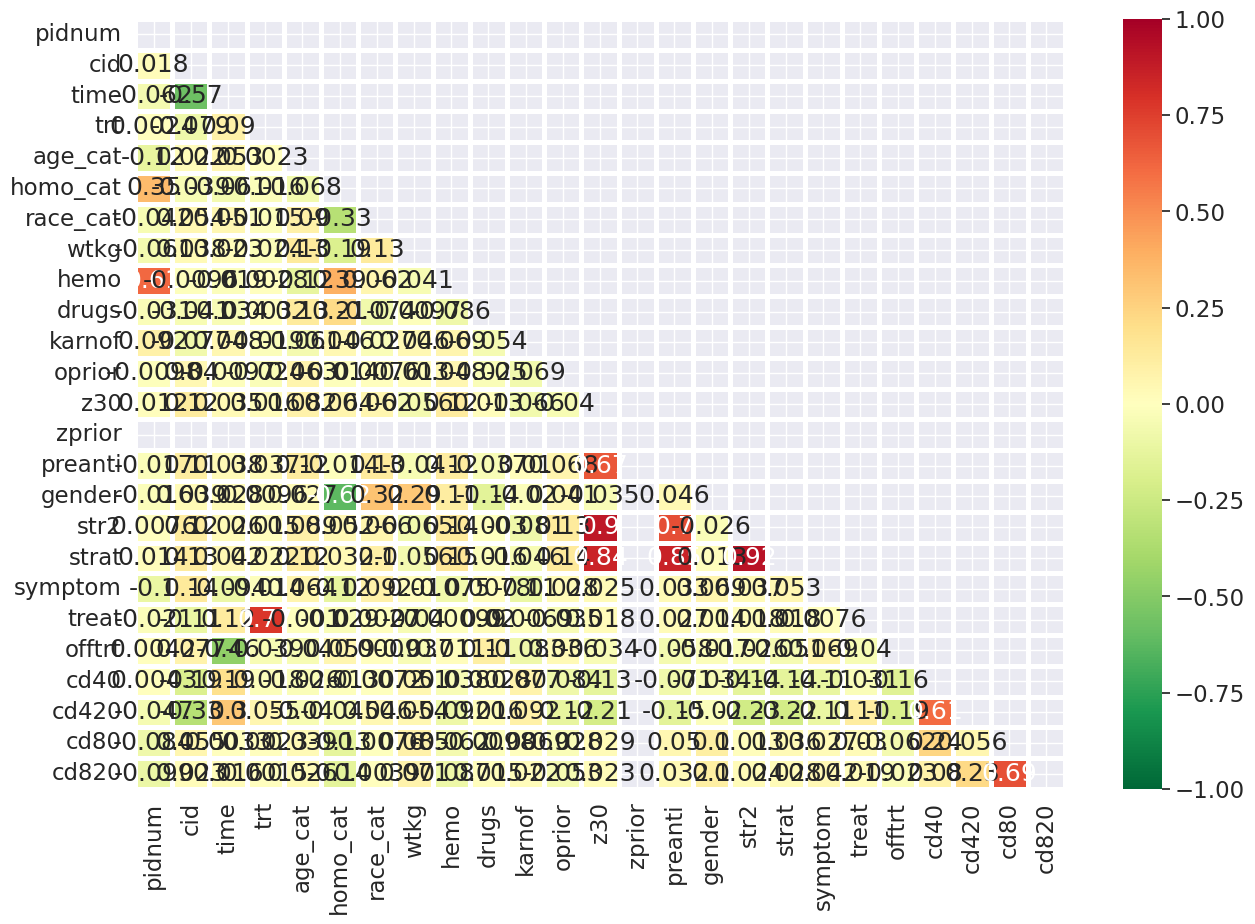

In [78]:
correlation_matrix = df_category.corr()
top_corr_features = correlation_matrix.index
print_heatmap(df_category[top_corr_features].corr())

The attribute 'zprior' is not correlated to any other attribute. After visualizing that the only value value for that attribute for all the samples in the dataset is 1, it was decided to drop it

In [79]:
df['zprior'].value_counts()

,count
zprior,
1,1818


In [80]:
df_category.drop('zprior', axis=1, inplace=True)

In [81]:
df_category.head(6)

,pidnum,cid,time,trt,age_cat,homo_cat,race_cat,wtkg,hemo,drugs,...,gender,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820
0,10056,0,948,2,1,1,1,89.8128,0,0,...,0,0,1,0,1,0,422,477,566,324
3,10093,0,1166,3,1,0,1,85.2768,0,0,...,1,1,3,0,1,0,287,394,1590,966
4,10124,0,1090,0,1,0,1,66.6792,0,0,...,1,1,3,0,0,0,504,353,870,782
5,10140,0,1181,1,1,0,1,88.9056,0,1,...,1,1,3,0,1,0,235,339,860,1060
6,10165,1,794,0,0,0,1,73.0296,0,0,...,1,1,3,0,0,0,244,225,708,699
7,10190,0,957,0,1,0,1,66.2256,0,1,...,1,1,3,0,0,0,401,366,889,720


The dataset is finally shuffled to avoid errors while training

In [82]:
df_category = df_category.sample(frac=1)
df_category.head()

,pidnum,cid,time,trt,age_cat,homo_cat,race_cat,wtkg,hemo,drugs,...,gender,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820
1464,260879,0,916,1,0,0,1,69.8000,0,1,...,1,0,1,0,1,1,435,459,886,855
844,150477,0,992,0,1,0,1,69.3000,0,1,...,1,1,3,0,0,1,267,272,839,842
251,50233,0,1231,2,1,0,1,72.5000,0,0,...,1,1,3,0,1,0,486,464,986,967
1655,310231,0,966,3,1,1,1,73.0296,1,1,...,1,0,1,0,1,0,480,403,700,864
2042,940519,1,314,0,0,1,0,56.8000,1,0,...,1,1,3,0,0,0,276,150,1279,805


## Visualisation


A first interesting aspect is to plot the target variable distribution, in order to have a general view of the outcome.  
From the plot we can see the distribution of the target variable.

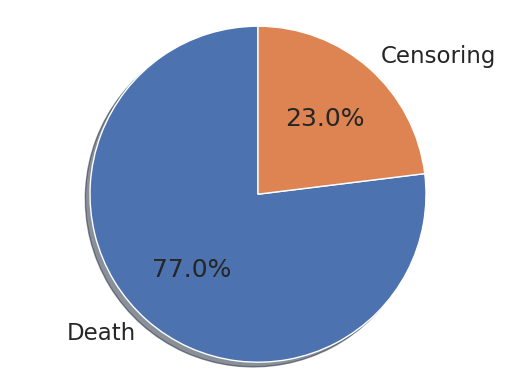

In [83]:
size0, size1 = df[Y].value_counts()
sizes = [size0, size1]
explode = (0, 0)
fig1, ax1= plt.subplots()
ax1.pie(sizes,explode=explode,labels=Y_labels,autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()


**Plot Protected Attributes**

Name mapping for the sensible attribute

It is possible to decide how to map the sensible attribute values to the labels, as shown in the next code cell, by modifying the `sensible_attribute_map` dictionary.

`G` is the list of sensible attributes to use for bias mitigation.

In [84]:
G = ['gender','age_cat', 'homo_cat', 'race_cat']

In [85]:
gender_attribute_map = {
    0: "Female",
    1: "Male",
}

In [86]:
age_attribute_map = {
    0: "Young",
    1: "Adult",
}

In [87]:
homo_attribute_map = {
    0: "Homosexual",
    1: "Non-Homosexual",
}

In [88]:
race_attribute_map = {
    0: "Non-White",
    1: "White",
}

In [89]:
sensible_attribute_map = {
    'age_cat': age_attribute_map,
    'gender': gender_attribute_map,
    'homo_cat': homo_attribute_map,
    'race_cat': race_attribute_map,
}

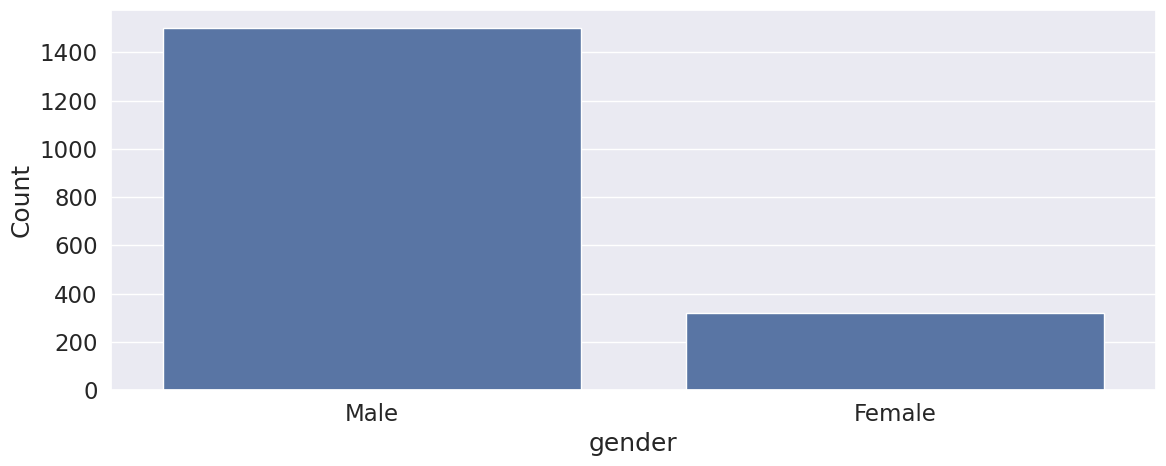

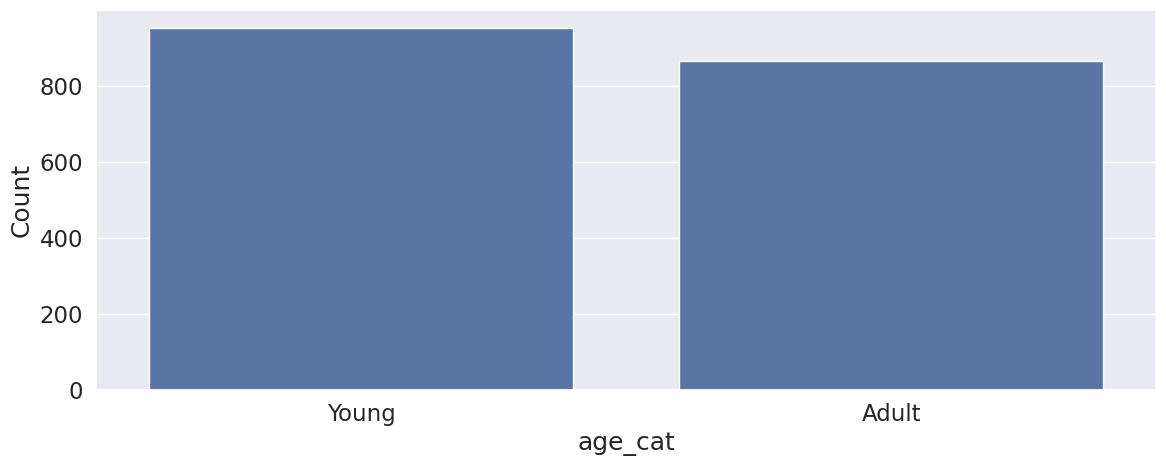

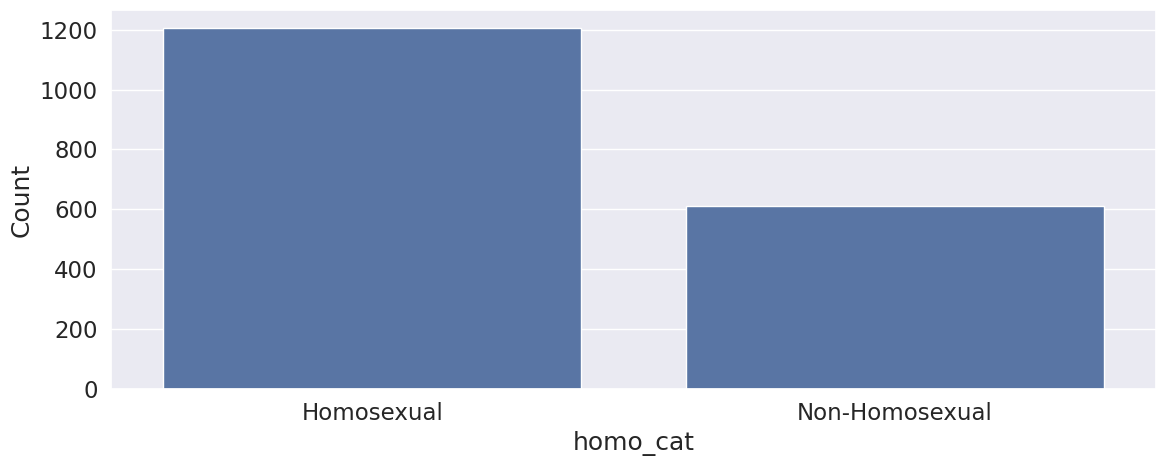

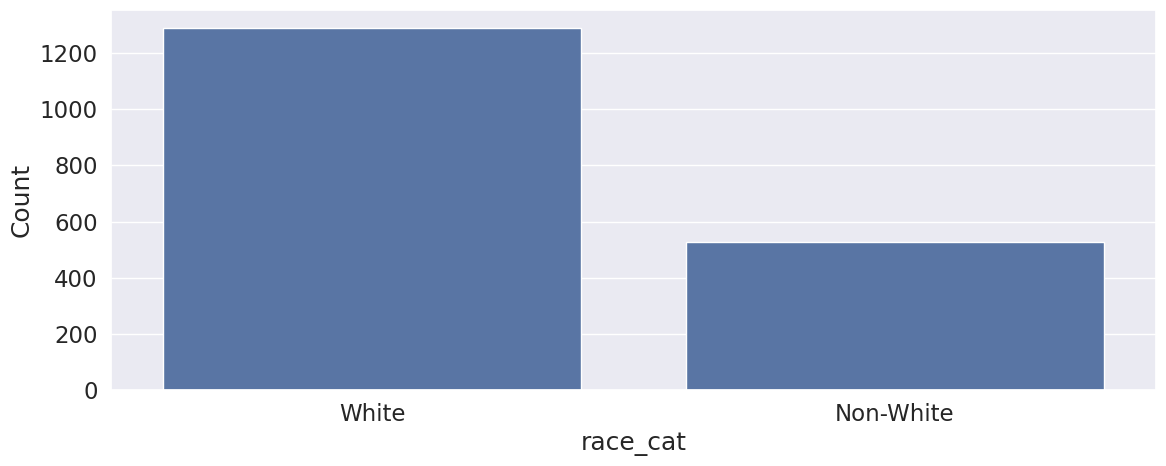

In [90]:
df_copy = df.copy()
for attribute in G:
    df_copy[attribute] = df_copy[attribute].map(sensible_attribute_map[attribute])
    visualize_att_dist(df_copy, attribute, _category=True)

# Statistics on the preprocessed dataset
Information about the dataset.

Percentage of samples for each protected attribute and the target.

In [91]:
samples = df.shape[0]

In [92]:
#race
race = 'race_cat'
race_zero = df[df[race] == 0]
count_race_zero = len(race_zero)
print(f"percentage of samples with race = 0 (non-white) : {count_race_zero/samples}")

race_one = df[df[race] == 1]
count_race_one = len(race_one)
print(f"percentage of samples with race = 1 (white): {count_race_one/samples}")


percentage of samples with race = 0 (non-white) : 0.290979097909791

percentage of samples with race = 1 (white): 0.7090209020902091

In [93]:
homo = 'homo_cat'
homo_zero = df[df[homo] == 0]
count_homo_zero = len(homo_zero)
print(f"percentage of samples with homo = 0 (homosexual): {count_homo_zero/samples}")

homo_one = df[df[homo] == 1]
count_homo_one = len(homo_one)
print(f"percentage of samples with homo = 1 (non-homosexual): {count_homo_one/samples}")

percentage of samples with homo = 0 (homosexual): 0.6628162816281629

percentage of samples with homo = 1 (non-homosexual): 0.3371837183718372

In [94]:
#age
age_zero = df[df['age_cat'] == 0]
count_age_zero = len(age_zero)
print(f"number samples with age= 0 (<= 34): {count_age_zero/samples}")

age_one = df[df['age_cat'] == 1]
count_age_one = len(age_one)
print(f"number samples with age = 1 (> 34): {count_age_one/samples}")


number samples with age= 0 (<= 34): 0.5236523652365237

number samples with age = 1 (> 34): 0.47634763476347636

In [95]:
#gender
gender = 'gender'
gender_zero = df[df[gender] == 0]
count_gender_zero = len(gender_zero)
print(f"number samples with gender = 0 (female): {count_gender_zero/samples}")

gender_one = df[df[gender] == 1]
count_gender_one = len(gender_one)
print(f"number samples with gender = 1 (male): {count_gender_one/samples}")

number samples with gender = 0 (female): 0.17491749174917492

number samples with gender = 1 (male): 0.8250825082508251

In [96]:
#mortality, target
mortality_counts = df['cid'].value_counts()
print(f"number of samples per mortality: {mortality_counts}")
print(f"percentage of samples per mortality: {mortality_counts /samples}")

number of samples per mortality: cid
0    1399
1     419
Name: count, dtype: int64

percentage of samples per mortality: cid
0    0.769527
1    0.230473
Name: count, dtype: float64

Percentage of samples for each protected attribute value and for each value of target class.

In [97]:
#race
filtered_samples = df[(df[race] == 0) & (df['cid'] == 0)]
count_filtered_samples = len(filtered_samples)
print(f"Percentage of samples where cid = 0 given race = 0: {count_filtered_samples/count_race_zero}")

filtered_samples = df[(df[race] == 1) & (df['cid'] == 0)]
count_filtered_samples = len(filtered_samples)
print(f"Percentage of samples where cid = 0 given race = 1: {count_filtered_samples/count_race_one}")

filtered_samples = df[(df[race] == 0) & (df['cid'] == 1)]
count_filtered_samples = len(filtered_samples)
print(f"Percentage of samples where cid = 1 given race = 0: {count_filtered_samples/count_race_zero}")

filtered_samples = df[(df[race] == 1) & (df['cid'] == 1)]
count_filtered_samples = len(filtered_samples)
print(f"Percentage of samples where cid = 1 given race = 1: {count_filtered_samples/count_race_one}")


Percentage of samples where cid = 0 given race = 0: 0.8052930056710775

Percentage of samples where cid = 0 given race = 1: 0.7548487199379363

Percentage of samples where cid = 1 given race = 0: 0.1947069943289225

Percentage of samples where cid = 1 given race = 1: 0.2451512800620636

In [98]:
#homo
filtered_samples = df[(df[homo] == 0) & (df['cid'] == 0)]
count_filtered_samples = len(filtered_samples)
print(f"Percentage of samples where cid = 0 given homo = 0: {count_filtered_samples/count_homo_zero}")

filtered_samples = df[(df[homo] == 1) & (df['cid'] == 0)]
count_filtered_samples = len(filtered_samples)
print(f"Percentage of samples where cid = 0 given homo = 1: {count_filtered_samples/count_homo_one}")

filtered_samples = df[(df[homo] == 0) & (df['cid'] == 1)]
count_filtered_samples = len(filtered_samples)
print(f"Percentage of samples where cid = 1 given homo = 0: {count_filtered_samples/count_homo_zero}")

filtered_samples = df[(df[homo] == 1) & (df['cid'] == 1)]
count_filtered_samples = len(filtered_samples)
print(f"Percentage of samples where cid = 1 given homo = 1: {count_filtered_samples/count_homo_one}")


Percentage of samples where cid = 0 given homo = 0: 0.7576763485477178

Percentage of samples where cid = 0 given homo = 1: 0.7928221859706363

Percentage of samples where cid = 1 given homo = 0: 0.24232365145228216

Percentage of samples where cid = 1 given homo = 1: 0.20717781402936378

In [99]:
#age
filtered_samples = df[(df['age_cat'] == 0) & (df['cid'] == 0)]
count_filtered_samples = len(filtered_samples)
print(f"Percentage of samples where cid = 0 given age = 0: {count_filtered_samples/count_age_zero}")

filtered_samples = df[(df['age_cat'] == 1) & (df['cid'] == 0)]
count_filtered_samples = len(filtered_samples)
print(f"Percentage of samples where cid = 0 given age = 1: {count_filtered_samples/count_age_one}")

filtered_samples = df[(df['age_cat'] == 0) & (df['cid'] == 1)]
count_filtered_samples = len(filtered_samples)
print(f"Percentage of samples where cid = 1 given age = 0: {count_filtered_samples/count_age_zero}")

filtered_samples = df[(df['age_cat'] == 1) & (df['cid'] == 1)]
count_filtered_samples = len(filtered_samples)
print(f"Percentage of samples where cid = 1 given age = 1: {count_filtered_samples/count_age_one}")


Percentage of samples where cid = 0 given age = 0: 0.7783613445378151

Percentage of samples where cid = 0 given age = 1: 0.7598152424942263

Percentage of samples where cid = 1 given age = 0: 0.22163865546218486

Percentage of samples where cid = 1 given age = 1: 0.24018475750577367

In [100]:
#gender
filtered_samples = df[(df['gender'] == 0) & (df['cid'] == 0)]
count_filtered_samples = len(filtered_samples)
print(f"Percentage of samples where cid = 0 given gender = 0: {count_filtered_samples/count_gender_zero}")

filtered_samples = df[(df['gender'] == 1) & (df['cid'] == 0)]
count_filtered_samples = len(filtered_samples)
print(f"Percentage of samples where cid = 0 given gender = 1: {count_filtered_samples/count_gender_one}")

filtered_samples = df[(df['gender'] == 0) & (df['cid'] == 1)]
count_filtered_samples = len(filtered_samples)
print(f"Percentage of samples where cid = 1 given gender = 0: {count_filtered_samples/count_gender_zero}")

filtered_samples = df[(df['gender'] == 1) & (df['cid'] == 1)]
count_filtered_samples = len(filtered_samples)
print(f"Percentage of samples where cid = 1 given gender = 1: {count_filtered_samples/count_gender_one}")


Percentage of samples where cid = 0 given gender = 0: 0.8050314465408805

Percentage of samples where cid = 0 given gender = 1: 0.762

Percentage of samples where cid = 1 given gender = 0: 0.1949685534591195

Percentage of samples where cid = 1 given gender = 1: 0.238

## Save preprocessed dataset

In [101]:
saving_path = path_to_project + '/data/preprocessed/preprocessed-aids.csv' if IN_COLAB else 'data/preprocessed/preprocessed-aids.csv'
df_category.to_csv(saving_path, sep=',', index=False, encoding='utf-8')

In [102]:
path_to_project = '/content/drive/MyDrive/FairAlgorithm'
os.makedirs(path_to_project, exist_ok=True)

profile = ProfileReport(df, title='Aids Analysis')
html_file = profile.to_file(path_to_project + '/data/reports/aids_analysis.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]